# Hubble Law Part 1: Extragalactic Redshift
Author: Dylan Linthorne

## Objective: 
---

In the 1920's, there was a debate between astronomers on the existence of galaxies, or what they referred to as 'Island universes'. Known as the Great Debate, Harlow Shapley and Heber Curtis were at odds on origins of spiral galaxies. One thinking that these nebulae like objects are held within our galaxy, which was believed to be the entirety of our universe at the time, whereas the other postulated that their distances spanned much further than our milky way. It wasn't until Edwin P. Hubble discovered that distant galaxies were all moving away from the Milky Way (and the Local Group) that astronomers started to believe that these extragalactic objects existed. Not only that, the farther away he observed, the faster the objects were receding. He found the relationship that is now known as Hubble's Law: the recessional velocity of a galaxy is proportional to its distance from us,

 $$v = H_{0} \cdot d$$

Where  is the velocity along the observers line of sight in km/s,  is the distance to the object in parsecs, and  is the notorious Hubble constant. In our more modern context of astronomy, the Hubble constant is a fundamental constant indicating the expansion rate of spacetime and the age of our universe as a whole, and is studied extensively in the field of Cosmology. The value of the Hubble constant has seen drastic revisions throughout the last century. Even today there isn't a consensus. This is largely due to how involved the Hubble constant is within various fields of astronomy & cosmology. It shows up in the Cosmic Microwave Background (CMB), Structure Formation of the universe, as well as our standard candles (Cephiads, SNIa, etc). This is highlighted in Fig. (1).

<center> <img src="Figs/H0_vs_year-600px.jpeg"> </center>

Today's measurements of the Hubble constant are far more sophisticated than that of Hubble's original calculation. His original calculations put the Hubble constant to around 500 km/s/Mpc, more than five times current values. The reason for this discrepancy is our poor understanding of galactic distances in the early 20th century. At the time, galaxies were assumed to be much closer to us than where we know them to be today. This lab will focus on using similar methods to determining both the velocity and distances of galaxies in an attempt to calculate the Hubble constant. Let's see if we can do better than Hubble.

In [1]:
import pandas as pd            #for our data structuress
import numpy as np             #for manipulating data
import matplotlib as mpl       #for visualization
import scipy.optimize as sp             #for chi2 model fitting/minimization
import os

### Finding Radial Velocities of Galaxies:


The velocity is relatively easy for us to measure using the Doppler effect. An object in motion (in this case, being carried along by the expansion of space itself) will have its radiation (light) shifted in wavelength. For velocities much smaller than the speed of light, we can use the regular Doppler formula: 

$$\frac{\lambda - \lambda_0}{\lambda_0} = \frac{v}{c}$$

Where  is the measured wavelength,  is the wavelength measured in the rest frame,  is the velocity along that line of sight (radial velocity), and  is the speed of light. The quantity on the left side of this equation is usually called the redshift, and is denoted by the letter z. The velocity of the galaxy is determined by measuring the redshift of spectral lines in the spectrum of the galaxy. Most galaxies are rich in spectral features: the "K and H" lines of ionized calcium and the H-alpha line of hydrogen. 

Let's start by reading in the spectral data of a single galaxy and try to automate the process once we have a grasp on the process.Load a single raw data file of Normalized flux (column 1) and wavelength in Angstroms (column 2).

In [2]:
directory = 'NGCData/Spectra/';
files = (file for file in os.listdir(directory) 
         if os.path.isfile(os.path.join(directory, file)))

file = [directory + f for f in files if f.find("NGC") == False]
file

['NGCData/Spectra/NGC_1832.txt',
 'NGCData/Spectra/NGC_2903.txt',
 'NGCData/Spectra/NGC_3310.txt',
 'NGCData/Spectra/NGC_5548.txt',
 'NGCData/Spectra/NGC_1357.txt',
 'NGCData/Spectra/NGC_3227.txt',
 'NGCData/Spectra/NGC_6217.txt',
 'NGCData/Spectra/NGC_3147.txt',
 'NGCData/Spectra/NGC_4775.txt',
 'NGCData/Spectra/NGC_2276.txt']

Until the very end of the lab we'll use a single file to visualize our method of approach before we apply it to the entire dataset. Using numpy arraysa and ensureing the shapes are of column vectors

In [17]:
test_set = file[4]

data = np.loadtxt(test_set)
wavelength = np.array(data[:,0])
normal_flux = np.array(data[:,1])
print("Number of data points: " + str(normal_flux.shape[0]))

Number of data points: 1726


Next would be to inspect the spectral data by plotting each point. Making sure not to plot it with a line, as this can cause issues in interpretting noisy spectral data.

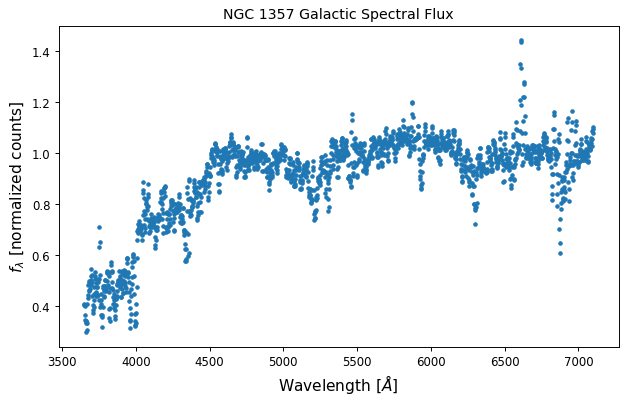

In [4]:
%matplotlib inline
fig, ax = mpl.pyplot.subplots(figsize=(8.5, 5), dpi=85)

ax.scatter(wavelength, normal_flux, s = 8);
ax.set_title("NGC 1357 Galactic Spectral Flux", fontsize=12);
ax.set_xlabel('Wavelength [$\AA$]', fontsize=13);
ax.set_ylabel('$f_{\lambda}$ [normalized counts]', fontsize=13);

These plots of "jiggly lines" are telling us all about these galaxies, just as stellar spectra tell us all about stars. Remember the primary objects found in spiral galaxies: stars of all ages, masses, and composition; dust; and HII regions. We expect, because the bright HII regions and massive OB stars will dominate the light of a spiral galaxy, to see strong emission lines of hydrogen. We can even see that the hydrogen alpha line is the strongest peak in the spectrum at 6562.8 Angstroms. To make it things visually easier to work with, let's focus the plot around some range around the suspected hydrogen alpha peak.

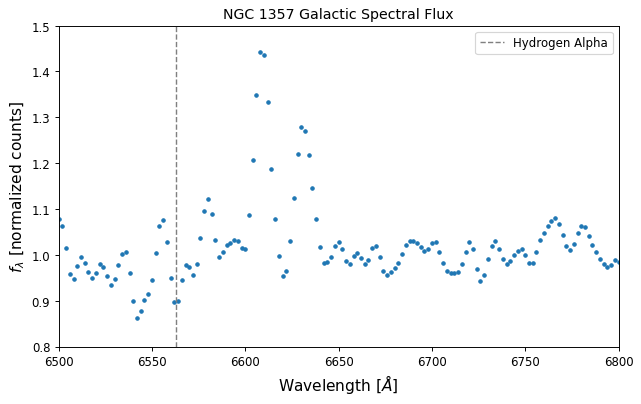

In [5]:
ax.set_xlim([6500,6800]);
ax.set_ylim([.8,1.5]);
ax.axvline(6562.8,linewidth=1.2, color='Gray', label = "Hydrogen Alpha", linestyle = "--")
ax.legend()
fig

### Smoothing the Spectra:

Not all of the lines come from the light of the galaxy. Each spectrum contains noise; we just cannot get away from it. You should notice that some of the spectra are much "noisier" than other spectra. This noise tends to hamper accurate identification of some of the lines. We can smooth out the function using a smoothing function; in this case, a N-point moving average smoother (we'll use 5-point) is build into scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.uniform_filter1d.html

$$y'(n) = (y(n-2) + y(n-1) + y(n) + y(n+1) + y(n+2))/5$$

In [6]:
from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import uniform_filter1d

Spline = make_interp_spline(wavelength, normal_flux)
smooth_flux = uniform_filter1d(normal_flux, size = 5)

Now plot the smoothed data on top of the original data to see if we can identify the lines better. Knowing visually where the unshifted hyrdrogen alpha line will make the inspection process easier for us. To do this, we'll add an annotated vertical line to overlay on our plot using xline(value).

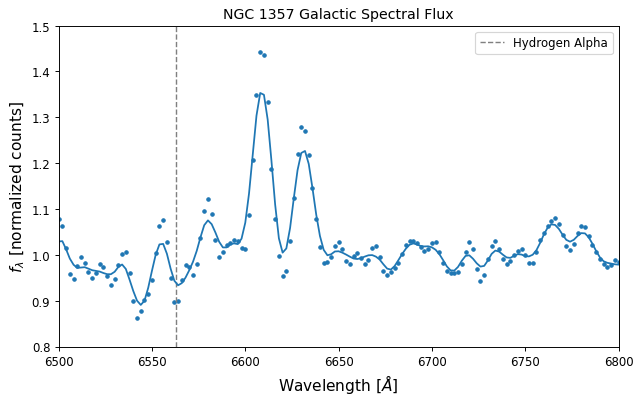

In [7]:
ax.plot(wavelength, smooth_flux, label = "Smoothed data");
fig

### Finding the Peaks:


Looking at the smoothed data we can easily point out the various emission and absorption lines of the galaxy. In our case, we're concerned with only the hydrogen alpha line which is an emission line. We can focus our attention on trying to find all of the maximums of the data instead of the minimum. It may look like a daunting task, luckily scipy provides us with in house peak finding algorithms, in the form of find_peaks(data). It takes in our (smoothed) data and gives pack multiple arguments, in order:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

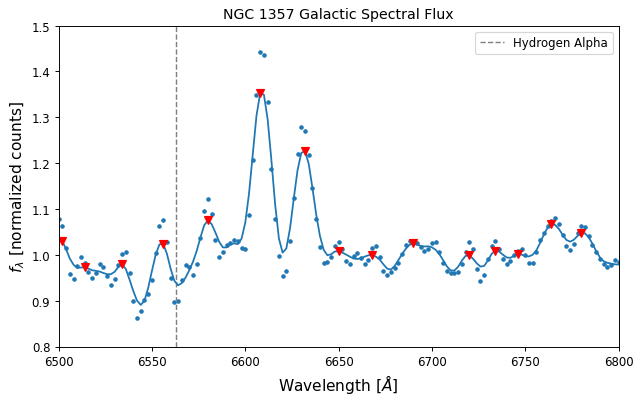

In [8]:
from scipy.signal import find_peaks
peaks, properties = find_peaks(smooth_flux,prominence=0, width=1)

peak_wavelength = np.array(wavelength[peaks])
peak_flux = np.array(smooth_flux[peaks])

ax.plot(peak_wavelength, peak_flux,'rv')
fig

From inspection we can notice that the data's hydrogen alpha peak $\lambda$ (the largest emission line peak) is to the right of the at rest hydrogen alpha line $\lambda_{o}$. Meaning, that our spectrum is redshifted and therefore moving away from us, in our line of sight. The next step would be to create a method of accessing the position of the max peak, and generalize it for all our galactic spectra. (Hint: Look up the max(data) and the numpy where(condition) functions). at the end you should have, the wavelength of the max peak $\lambda_{max}$, the value of it's prominence $f(\lambda_{max})$, and the corresponding width $w(\lambda_{max})$.

In [9]:
maxpk = max(peak_flux)
maxindex = np.where(peak_flux == maxpk)[0][0]
maxwavelength = peak_wavelength[maxindex]
maxwidth = properties['widths'][maxindex]

The target emission peak has been located and information has been extracted $\lambda_{max}, f(\lambda_{max}), w(\lambda_{max})$ . We'll use this information to check the consistency of the emission peak profile. Ideally, these emission and absorption lines are modelled by a Gaussian profile. Although this is not exactly correct. Spectral lines will be broadened and skewed by various astrophysical processes, such as rotation and pressure effects. Since we're dealing with galactic spectra, these effects are minimal compared to dense (and sometimes fastly rotating) stars. With this assumption, we'll fit a Gaussian profile over our shifted hydrogen alpha peak using the model,
$$ P(x| a_{1}, a_{2}, a_{3}, a_{4}) = a_{1} \cdot \text{exp}(-((x - a_{2})/a_{3})^2) + a_{4}$$

Here $a_1$ is the peak height, $a_2$ the corresponding central wavelength, $a_3$ encodes the width, and $a_4$ is a background shift. If you need a reminder of how to implement a model to data using the Least Squares/$\chi^2$ fitting function. First, we need to define the model function that we are choosing to fit using non-linear regression from scipy.

In [10]:
def gaussian(x, a1, a2, a3, a4):
    return a1*np.exp(-((x- a2)/a3)**2) + a4

To ensure that the fitter found our hydrogen alpha line we'll help it by setting "starting points" (or "most likely around here" points) and defining upper/lower bounds on each parameter. The starting points used will be equal to the values our max peak function found $(a_1,a_2,a_3) = (f(\lambda_{max}),\lambda_{max},w(\lambda_{max}))$  . We're missing the last parameter, the background $a_4$. 

You'll notice that the emission lines lay on top a background function, the full dataset slowly increasing and plateauing after Angstroms. If we had no emission or absorption lines in our spectra, the only thing left would be this background usually referred to as the continuum of the spectra. $a_{4}$ is only a constant, and therefore can't encapsulate all of the continuum background. Find a way to estimate, reducing the data to a single value. This, of course, could be the average value of our data. For better accuracy we'll probably want to focus our averaging for only the flat part of the continuum, near our emission peak in question. We'll call this variable bkg.

In [11]:
bkg_first_index = np.where(wavelength == 6500)[0][0]
bkg_second_index = np.where(wavelength == 6800)[0][0];
bkg = np.mean(smooth_flux[bkg_first_index:bkg_second_index]);

Now that we have our starting points, input them into the fit() function using the fit type already created. As mentioned above, a starting point and both, an upper and lower bound will be given to the fitter so to converge onto the proper emission line:
* Starting Point: $[f(\lambda_{max}),\lambda_{max},w(\lambda_{max}), bkg$]
* Upper Bound: $[a_{1}^{up},a_{2}^{up},a_{3}^{up},a_{4}^{up}]$
* Lower Bound: $[a_{1}^{low},a_{2}^{low},a_{3}^{low},a_{4}^{low}]$

Set your upper and lower bound values to what makes physically sense. Some tuning might be necessary to get the convergence right. 

In [12]:
coeff, var_matrix = sp.curve_fit(gaussian, wavelength, normal_flux, p0 =[maxpk,maxwavelength,maxwidth,bkg],
                                                            bounds=((0, 6500, 0, 0), (3, 6700, 15, np.inf)))

In [13]:
print("shape of coefficents: " + str(coeff.shape))
print("shape of covariance matrix: " + str(var_matrix.shape))

shape of coefficents: (4,)
shape of covariance matrix: (4, 4)


Inspecting the fitter output is one way of checking for consistency of our values. For full visual inspection we'll plot a Gaussian function with the parameters estimated with the fitter. To do so, create a vector of x-values (using linespace()) and create a new Gaussian function with the x-vector as input. Finally, plot it over our figure. 

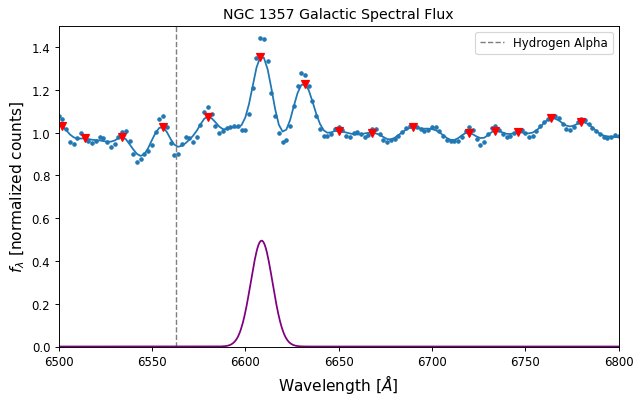

In [14]:
x_sample = np.linspace(6500,7000,1000);

ax.plot(x_sample, gaussian(x_sample,coeff[0],coeff[1],coeff[2],0),'purple')
ax.set_ylim([0,1.5]);
fig

### Putting it all Together to Calculate $\lambda_{H\alpha}$:

The goal of this lab is to find the reshifts, and correspondingly the radial velocities, of the galaxies surveyed in:(put database here). So far, we've spoken about a single galaxies spectrum. It's now time to put it all together by looping over all datasets in folder (folder name). Creating an array of all of the final radial velocities in order of the filenames. You're for loop should contain the following steps in order

* Read in the $i^{th}$ file in the directory.
* Smooth the flux data.
* Find $f(\lambda_{max}),\lambda_{max},w(\lambda_{max})$ for each file.
* Calculate the redshift and save it in an array.
* Save the widths into an array.

In [15]:
i = 0;
redshift = np.zeros(len(file));
linewidth = np.zeros(len(file));

for f in file:    
    data = np.loadtxt(f)
    
    wave = np.array(data[:,0])
    flux = uniform_filter1d(np.array(data[:,1]),size = 5)
    
    peaks, properties = find_peaks(flux,prominence=0, width=1)

    peak_wave = np.array(wave[peaks])
    peak_flux = np.array(flux[peaks])

    maxpk = max(flux)
    maxindex = np.where(peak_flux == maxpk)[0][0]
    maxwavelength = peak_wave[maxindex]
    maxwidth = properties['widths'][maxindex]

    
    redshift[i] = (maxwavelength - 6563.0)/6563.0;
    linewidth[i] = maxwidth/1.5;
    i = i + 1;   

### Write to file:
Write the output into a file for use later.
